In [251]:
import re
import nltk
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
!python -m nltk.downloader stopwords wordnet punkt averaged_perceptron_tagger
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.layers import Attention
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
!pip install rouge
from rouge import Rouge

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Hyperparameters

In [0]:
BATCH_SIZE=50
EPOCHS=50
latent_dim=128
embedding_dim=128
test_train_split=0.15
build_number="1"
LEARNING_RATE=0.001

In [0]:
# create rouge object for evaluation
rouge = Rouge()

## Data Processing

Read In Data

In [314]:
# Only needed if running on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [362]:
df = pd.read_csv('./drive/My Drive/repeat.csv')
# df = pd.read_csv('./Reviews.csv')
df.head(1)

,Unnamed: 0,file,text,summary
0,0,0001d1afc246a7964130f43ae940af6bc6c57f01.story,Its official US President Barack Obama want la...,Syrian official Obama climbed top tree doesnt ...


In [363]:
df.count

<bound method DataFrame.count of       Unnamed: 0  ...                                            summary
0              0  ...  Syrian official Obama climbed top tree doesnt ...
1              1  ...  Syrian official Obama climbed top tree doesnt ...
2              2  ...  Syrian official Obama climbed top tree doesnt ...
3              3  ...  Syrian official Obama climbed top tree doesnt ...
4              4  ...  Syrian official Obama climbed top tree doesnt ...
...          ...  ...                                                ...
5111        5111  ...  Syrian official Obama climbed top tree doesnt ...
5112        5112  ...  Syrian official Obama climbed top tree doesnt ...
5113        5113  ...  Syrian official Obama climbed top tree doesnt ...
5114        5114  ...  Syrian official Obama climbed top tree doesnt ...
5115        5115  ...  Syrian official Obama climbed top tree doesnt ...

[5116 rows x 4 columns]>

Split for now so we are only aiming for one summary per text (This is now in dataprocessing.py

In [365]:
df.head()

,Unnamed: 0,file,text,summary
0,0,0001d1afc246a7964130f43ae940af6bc6c57f01.story,Its official US President Barack Obama want la...,Syrian official Obama climbed top tree doesnt ...
1,1,0002095e55fcbd3a2f366d9bf92a95433dc305ef.story,Its official US President Barack Obama want la...,Syrian official Obama climbed top tree doesnt ...
2,2,00027e965c8264c35cc1bc55556db388da82b07f.story,Its official US President Barack Obama want la...,Syrian official Obama climbed top tree doesnt ...
3,3,0002c17436637c4fe1837c935c04de47adb18e9a.story,Its official US President Barack Obama want la...,Syrian official Obama climbed top tree doesnt ...
4,4,0003ad6ef0c37534f80b55b4235108024b407f0b.story,Its official US President Barack Obama want la...,Syrian official Obama climbed top tree doesnt ...


In [366]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: re.sub(r'\..*$',' ',str(x)))
print(df['summary'][0])

Syrian official Obama climbed top tree doesnt know get Obama sends letter heads House Senate Obama seek congressional approval military action Syria Aim determine whether CW used says U.N. spokesman
Syrian official Obama climbed top tree doesnt know get Obama sends letter heads House Senate Obama seek congressional approval military action Syria Aim determine whether CW used says U 


Remove .'s that appear in stuff like U.S.A and U.N - Eventually need to move this to dataprocessing.py

In [367]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: re.sub(r'\.','',str(x)))
print(df['summary'][0])

Syrian official Obama climbed top tree doesnt know get Obama sends letter heads House Senate Obama seek congressional approval military action Syria Aim determine whether CW used says U 
Syrian official Obama climbed top tree doesnt know get Obama sends letter heads House Senate Obama seek congressional approval military action Syria Aim determine whether CW used says U 


Check for rows with null values in them, and copy these into a new dataframe (df1). Drop any rows in df1 from df to ensure no NaN valued rows are present/

*Note. using simply dropna(how='any') does not seem to drop any of the rows*

In [368]:
print(df.isnull().values.any())
print(df.shape)

df1 = df[df.isna().any(axis=1)]
print(df1.shape)

df.drop(df1.index, axis=0,inplace=True)
print(df.shape)
print(df.isnull().values.any())

False
(5116, 4)
(0, 4)
(5116, 4)
False


In [369]:
print(df['text'][0])
df['text'] = df['text'].apply(lambda x: x)
print(df['text'][0])

Its official US President Barack Obama want lawmaker weigh whether use military force Syria Obama sent letter head House Senate Saturday night hour announce believe military action Syrian target right step take allege use chemical weapon The propose legislation Obama asks Congress approve use military force deter disrupt prevent degrade potential future us chemical weapon weapon mass destruction Its step set turn international crisis fierce domestic political battle There key question loom debate What UN weapon inspector find Syria What happens Congress vote And Syrian government react In televise address White House Rose Garden earlier Saturday president say would take case Congress want While I believe I authority carry military action without specific congressional authorization I know country strong take course action even effective say We debate issue big business usual Obama say top congressional leader agree schedule debate body return Washington September 9 The Senate Foreign R

In [370]:
print(df['text'][5])

Its official US President Barack Obama want lawmaker weigh whether use military force Syria Obama sent letter head House Senate Saturday night hour announce believe military action Syrian target right step take allege use chemical weapon The propose legislation Obama asks Congress approve use military force deter disrupt prevent degrade potential future us chemical weapon weapon mass destruction Its step set turn international crisis fierce domestic political battle There key question loom debate What UN weapon inspector find Syria What happens Congress vote And Syrian government react In televise address White House Rose Garden earlier Saturday president say would take case Congress want While I believe I authority carry military action without specific congressional authorization I know country strong take course action even effective say We debate issue big business usual Obama say top congressional leader agree schedule debate body return Washington September 9 The Senate Foreign R

In [371]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: x)
print(df['summary'][0])
print(df['summary'][500])

Syrian official Obama climbed top tree doesnt know get Obama sends letter heads House Senate Obama seek congressional approval military action Syria Aim determine whether CW used says U 
Syrian official Obama climbed top tree doesnt know get Obama sends letter heads House Senate Obama seek congressional approval military action Syria Aim determine whether CW used says U 
Syrian official Obama climbed top tree doesnt know get Obama sends letter heads House Senate Obama seek congressional approval military action Syria Aim determine whether CW used says U 


Word Count Distribution

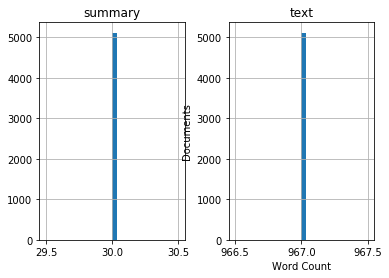

In [372]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split(' ')))

for i in df['summary']:
      summary_word_count.append(len(i.split(' ')))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.ylabel('Documents')
plt.xlabel('Word Count')
plt.savefig('word_count_distro' + str(build_number) + '.png')
plt.show()

Max Text Lengths

In [373]:
max_text_len = max([len(txt.split(' ')) for txt in df['text']])
max_summary_len = max([len(txt.split(' ')) for txt in df['summary']])
print(max_text_len)
print(max_summary_len)

967
30


### Training-Validation Split

X - Articles text </br>
Y - Summaries

In [0]:
# convert to numpy array
X = np.array(df['text'])
Y = np.array(df['summary'])

In [375]:
x_tr,x_val,y_tr,y_val=train_test_split(X,Y,test_size=test_train_split,random_state=0,shuffle=True)
print(x_tr.shape)
print(x_val.shape)
print(y_tr.shape)
print(y_val.shape)

(4348,)
(768,)
(4348,)
(768,)


### Word Embeddings - Tokenization

X Tokenizer

In [376]:
word_dict = {}
text = df['text']

for row in text: 
  for word in row.split(" "):
    if word not in word_dict:
      word_dict[word] = 1
    else:
      word_dict[word] += 1

print(len(word_dict))

506


In [377]:
# #prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=len(word_dict), split=" ") 
print(x_tokenizer)
x_tokenizer.fit_on_texts(list(X))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words
print(x_voc)

506


In [0]:
with open('xtokenizer.pickle', 'wb') as handle:
  pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Y Tokenizer

In [379]:
y_word_dict = {}
summ = df['summary']

for row in summ: 
  for word in row.split(" "):
    if word not in y_word_dict:
      y_word_dict[word] = 1
    else:
      y_word_dict[word] += 1

print(len(y_word_dict))

28


In [380]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=len(y_word_dict), split=" ") 
y_tokenizer.fit_on_texts(list(Y))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words
print(y_voc)

28


In [0]:
with open('ytokenizer.pickle', 'wb') as handle:
  pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Learning Model

#### Encoder Model

In [0]:
encoder_inputs = Input(shape=(max_text_len,))
#embedding layer
enc_emb =  Embedding(x_voc,embedding_dim,trainable=True)(encoder_inputs)
#encoder lstm 
encoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

#### Decoder Model

In [0]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
                                                          
#dense layer
decoder_dense = Dense(y_voc, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#### Combined LSTM Model

In [384]:
# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 967)          0                                            
__________________________________________________________________________________________________
input_46 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 967, 128)     64768       input_45[0][0]                   
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, None, 128)    3584        input_46[0][0]                   
___________________________________________________________________________________________

In [0]:
optimizer = RMSprop(lr=LEARNING_RATE, rho=0.9)

In [0]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

- Early Stopping Callback to ensure we stop when Validation Loss is lowest - minimises risk of overfitting
- Model Checkpoint saves the model after each epoch so that we can load the model with the best weights later on. Alternatively, it allows us to continue training the model at a later data



In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5, restore_best_weights=False)
filepath = "./drive/My Drive/project-model/saved-model-{epoch:02d}.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#### Use this method to train a new model. To continue training a previously trained model see below

In [388]:
history = model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:], batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[es], validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 4348 samples, validate on 768 samples
Epoch 1/50
4348/4348 [==============================] - 134s 31ms/step - loss: 1.5710 - val_loss: 0.7118
Epoch 2/50
4348/4348 [==============================] - 131s 30ms/step - loss: 0.3051 - val_loss: 0.0491
Epoch 3/50
4348/4348 [==============================] - 133s 31ms/step - loss: 0.0122 - val_loss: 6.5693e-04
Epoch 4/50
4348/4348 [==============================] - 132s 30ms/step - loss: 1.5865e-04 - val_loss: 1.4905e-05
Epoch 5/50
4348/4348 [==============================] - 132s 30ms/step - loss: 6.6150e-06 - val_loss: 3.6092e-06
Epoch 6/50
4348/4348 [==============================] - 131s 30ms/step - loss: 3.1678e-06 - val_loss: 2.9227e-06
Epoch 7/50
4348/4348 [==============================] - 132s 30ms/step - loss: 2.8477e-06 - val_loss: 2.8158e-06
Epoch 8/50
4348/4348 [==============================] - 130s 30ms/step - loss: 2.8118e-06 - val_loss: 2.8117e-06
Epoch 9/50
4348/4348 [==============================] - 132s 30ms/ste

#### This method is to only be used when loading a previously partially trained model

In [0]:
# model = load_model("./drive/My Drive/project-model/saved-model-53.hdf5")
# history = model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:], callbacks=[mc], batch_size=BATCH_SIZE, epochs=1, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('loss' + str(build_number) + '.png')
plt.show()

## Inference Model

In [0]:
# load model from drive
# model = load_model("./drive/My Drive/saved-model-53.hdf5")

In [392]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
print(reverse_source_word_index)
print(reverse_target_word_index)

{1: 'say', 2: 'syria', 3: 'military', 4: 'obama', 5: 'us', 6: 'syrian', 7: 'action', 8: 'weapon', 9: 'use', 10: 'obamas', 11: 'saturday', 12: 'chemical', 13: 'president', 14: 'the', 15: 'congress', 16: 'take', 17: 'un', 18: 'would', 19: 'official', 20: 'attack', 21: 'lawmaker', 22: 'debate', 23: 'inspector', 24: 'united', 25: 'state', 26: 'force', 27: 'political', 28: 'what', 29: 'government', 30: 'i', 31: 'report', 32: 'support', 33: 'get', 34: 'syrias', 35: 'states', 36: 'want', 37: 'house', 38: 'step', 39: 'crisis', 40: 'key', 41: 'vote', 42: 'earlier', 43: 'country', 44: 'top', 45: 'leader', 46: 'come', 47: 'week', 48: 'told', 49: 'british', 50: 'could', 51: 'a', 52: 'speech', 53: 'cameron', 54: 'its', 55: 'whether', 56: 'night', 57: 'turn', 58: 'international', 59: 'in', 60: 'authorization', 61: 'issue', 62: 'spokesman', 63: 'global', 64: 'intelligence', 65: 'ban', 66: 'must', 67: 'confront', 68: 'some', 69: 'on', 70: 'group', 71: 'people', 72: 'world', 73: 'strike', 74: 'decision

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_inputs)

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + [state_h2, state_c2])

In [394]:
encoder_model.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        (None, 967)               0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 967, 128)          64768     
_________________________________________________________________
lstm_15 (LSTM)               [(None, 967, 128), (None, 131584    
Total params: 196,352
Trainable params: 196,352
Non-trainable params: 0
_________________________________________________________________


In [395]:
decoder_model.summary()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, None, 128)    3584        input_46[0][0]                   
__________________________________________________________________________________________________
input_47 (InputLayer)           (None, 128)          0                                            
__________________________________________________________________________________________________
input_48 (InputLayer)           (None, 128)          0                                            
___________________________________________________________________________________________

### Methhods for Reversing Word Embeddings

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

### Summarisation Method 

In [0]:
def decode_sequence(input_seq): 
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, max_summary_len))
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
      output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) 
      # print(output_tokens[0, -1, :][1:])
      sampled_token_index = np.argmax(output_tokens[0, -1, :][1:])
      # print(sampled_token_index)
      # print(sampled_token_index)
      if (sampled_token_index != 0 ):
        sampled_token = reverse_target_word_index[sampled_token_index]
        decoded_sentence += ' '+sampled_token
      else :
        print("sadface")
        stop_condition = True
      if (len(decoded_sentence.split()) >= (max_summary_len-1)):
              stop_condition = True
       # Update the target sequence (of length 1).
      # target_seq = np.zeros((1,1))
      target_seq = np.zeros((1, max_summary_len))
      target_seq[0, sampled_token_index] = 1

      # Update internal states
      e_h, e_c = h, c
      
    return decoded_sentence

## Test Model Output

Note: *I think there isn't enough data being passed in and so the argmax value always is 0 - it can't learn what should be next*

In [0]:
def getRouge(gt, pred):
  return rouge.get_scores(pred, gt)

In [429]:
for i in range(0,1):
    print("Article:",seq2text(x_tr[i]))
    original = seq2summary(y_tr[i])
    print("Original summary:",original)
    summary = decode_sequence(x_tr)
    print("Generated summary:",summary)
    print("\n")
    print("ROUGE score: ")
    score = getRouge(str(summary), str(original))
    print(score)
    print(score[0].get('rouge-1').get('f'))
    print(score[0].get('rouge-1').get('p'))
    print(score[0].get('rouge-1').get('r'))

Article: its official us president barack obama want lawmaker weigh whether use military force syria obama sent letter head house senate saturday night hour announce believe military action syrian target right step take allege use chemical weapon the propose legislation obama asks congress approve use military force deter disrupt prevent degrade potential future us chemical weapon weapon mass destruction its step set turn international crisis fierce domestic political battle there key question loom debate what un weapon inspector find syria what happens congress vote and syrian government react in televise address white house rose garden earlier saturday president say would take case congress want while i believe i authority carry military action without specific congressional authorization i know country strong take course action even effective say we debate issue big business usual obama say top congressional leader agree schedule debate body return washington september 9 the senate 

## Evaluation

Using ROUGE (Recall-Orientated Understanding Gisting Evaluation) to evaluate the generated summaries

In [0]:
def get_overlapping_words(x, y):
  num=0
  x = nltk.word_tokenize(x)
  y = nltk.word_tokenize(y)
  for word in y:
    if word in x:
      num = num+1
      x.remove(word)
    else:
      return num

def precision(target, generated):
  length = len(target)
  for i in range (0, length):
    num_overlapping_words = get_overlapping_words(target[i], generated[i])
    generated_summary_len = len(generated[i])
    if generated_summary_len == 0 :
        return 0.0
    else : 
      return num_overlapping_words / generated_summary_len

### For Training Data

In [417]:
print(len(x_tr))

4348


In [426]:
tr_target_summary = []
tr_generated_summary = []
x_tr_len = len(x_tr)

f_ov = 0
p_ov = 0
r_ov = 0
# x_val_len = 1
for i in range(0,x_tr_len):
  original = seq2text(y_tr[i])
  tr_target_summary.append(original)
  x_i = x_tr[i].reshape(1,max_text_len)
  summary = decode_sequence(x_i)
  tr_generated_summary.append(summary)
  score = getRouge(str(summary), str(original))
  f_ov += float(score[0].get('rouge-1').get('f'))
  p_ov += float(score[0].get('rouge-1').get('p'))
  r_ov += float(score[0].get('rouge-1').get('r'))

syria military say obama us syrian action weapon use say obamas saturday chemical president the say congress take un would official attack lawmaker debate inspector united state force political 
 cw says sends approval cw tree sends military used tree heads action says know heads action says know heads action says know heads action says know heads syria says
[{'rouge-1': {'f': 0.15789473272853197, 'p': 0.1111111111111111, 'r': 0.2727272727272727}, 'rouge-2': {'f': 0.0, 'p': 0.0, 'r': 0.0}, 'rouge-l': {'f': 0.0808984486527917, 'p': 0.07407407407407407, 'r': 0.18181818181818182}}]
syria military say obama us syrian action weapon use say obamas saturday chemical president the say congress take un would official attack lawmaker debate inspector united state force political 
 cw says sends approval cw tree sends military used tree heads action says know heads action says know heads action says know heads action says know heads syria says
[{'rouge-1': {'f': 0.15789473272853197, 'p': 0.111111

In [428]:
# print("precision : " + str(precision(tr_target_summary, tr_generated_summary)))
print("Avg F Score: " + str(f_ov/x_tr_len))
print("Avg Precision: " + str(p_ov/x_tr_len))
print("Avg Recall: " + str(r_ov/x_tr_len))

Avg F Score: 0.15789473272853197
Avg Precision: 0.11111111111111112
Avg Recall: 0.2727272727272727


### For Validation Data

In [0]:
val_target_summary = []
val_generated_summary = []
x_val_len = len(x_val)
f_ov = 0
p_ov = 0
r_ov = 0

for i in range(0,x_val_len):
  original = seq2text(y_val[i])
  val_target_summary.append(original)
  x_i = x_val[i].reshape(1,max_text_len)
  summary = decode_sequence(x_i)
  val_generated_summary.append(summary)
  score = getRouge(str(summary), str(original))
  f_ov += float(score[0].get('rouge-1').get('f'))
  p_ov += float(score[0].get('rouge-1').get('p'))
  r_ov += float(score[0].get('rouge-1').get('r'))

In [0]:
print("precision : " + str(precision(val_target_summary, val_generated_summary)))
print("Avg F Score: " + str(f_ov/x_val_len))
print("Avg Precision: " + str(p_ov/x_val_len))
print("Avg Recall: " + str(r_ov/x_val_len))

# Inputting New Data

In [0]:
def getpos(word):
  pos = nltk.pos_tag([word])[0][1][0]
  wordnet_conv = {"J": wn.ADJ, "N": wn.NOUN, "V": wn.VERB, "R": wn.ADV}
  if pos in wordnet_conv.keys():
    return wordnet_conv.get(pos)
  return ""

In [0]:
def lemmatization(text):
  lemmatizer = WordNetLemmatizer()
  text_tokenized = inp_df['text'].apply(lambda x: nltk.word_tokenize(x))
  print("lemmatize with pos")
  for i in range(0,len(text_tokenized)):
    text_lemmatized = []
    for word in text_tokenized[i]:
      pos = getpos(word)
      if pos != "":
        lemma = lemmatizer.lemmatize(word, pos)
        text_lemmatized.append(lemma)
      else :
        text_lemmatized.append(word)
    text_lemmatized = ' '.join(map(str, text_lemmatized))
    inp_df['text'][i] = text_lemmatized


In [430]:
# input1 = "(CNN) — Earlier this year, Delta Air Lines announced a rethink on reclining seats. In an effort to disrupt fewer passengers' travel experiences, Delta said it'd begin revamping some of its jets to reduce the recline of coach seats from four inches to two inches and the recline of first class seats from 5.5 inches to 3.5 inches. For those who abhor the recline option, it's a small step. And for those who value it, well, it's a compromise. This seemingly innocuous topic is one where there are very much two minds on what's acceptable and what's not. Two CNN Travel staffers engage in a friendly debate about seat recline. Your seat. Your decision. Stacey Lastoe, senior editor at CNN Travel, is of above-average height and makes no apology about reclining; it's her right as a plane, train and bus passenger. She encourages the person sitting in front of her to recline as well. On the first leg of my flight to Japan for my honeymoon, my husband and I got upgraded to first class. Although it would just be a few hours in the sky en route to Dallas, I was excited about sipping Champagne, sitting back and relaxing. Flute in hand, I pushed back to recline my seat for maximum relaxation. But it would not budge; I appeared to be stuck in a dysfunctional seat. Or was I? Turns out the gentleman behind me had a dog in a crate down between his legs, positioned so the seat in front of his -- my seat -- had nowhere to go. Because we were newlyweds and loving every moment of it, I did not mind when my husband turned to the man and told him his wife wanted to recline her seat and asked if he could please rearrange his dog crate to allow for everyones comfort."
input1 = "Its official US President Barack Obama want lawmaker weigh whether use military force Syria Obama sent letter head House Senate Saturday night hour announce believe military action Syrian target right step take allege use chemical weapon The propose legislation Obama asks Congress approve use military force deter disrupt prevent degrade potential future us chemical weapon weapon mass destruction Its step set turn international crisis fierce domestic political battle There key question loom debate What UN weapon inspector find Syria What happens Congress vote And Syrian government react In televise address White House Rose Garden earlier Saturday president say would take case Congress want While I believe I authority carry military action without specific congressional authorization I know country strong take course action even effective say We debate issue big business usual Obama say top congressional leader agree schedule debate body return Washington September 9 The Senate Foreign Relations Committee hold hearing matter Tuesday Sen Robert Menendez say Transcript Read Obamas full remark Syrian crisis Latest development UN inspector leave Syria Obamas remark come shortly UN inspector left Syria carry evidence determine whether chemical weapon use attack early last week Damascus suburb The aim game mandate clear ascertain whether chemical weapon use UN spokesman Martin Nesirky told reporter Saturday But use weapon report toxic gas attack Damascus suburb August 21 key point global debate Syrian crisis Top US official say there doubt Syrian government behind Syrian official deny responsibility blame jihadist fight rebel British US intelligence report say attack involve chemical weapon UN official stress importance wait official report inspector The inspector share finding UN SecretaryGeneral Ban Kimoon Ban say want wait UN team final report complete present UN Security Council The Organization Prohibition Chemical Weapons nine inspector belong say Saturday could take three week analyze evidence collect It need time able analyze information sample Nesirky say He note Ban repeatedly say alternative political solution crisis Syria military solution option Bergen Syria problem hell US Obama This menace must confront Obamas senior adviser debate next step take president comment Saturday come amid mount political pressure situation Syria Some US lawmaker call immediate action others warn step could become quagmire Some global leader express support British Parliaments vote military action earlier week blow Obamas hope get strong backing key NATO ally On Saturday Obama propose say would limited military action Syrian President Bashar alAssad Any military attack would openended include US ground force say Syrias allege use chemical weapon earlier month assault human dignity president say A failure respond force Obama argue could lead escalate use chemical weapon proliferation terrorist group would people harm In world many danger menace must confront Syria missile strike What would happen next Map US allied asset around Syria Obama decision come Friday night On Friday night president make lastminute decision consult lawmaker What happen vote Its unclear A senior administration official told CNN Obama authority act without Congress even Congress reject request authorization use force Obama Saturday continued shore support strike alAssad government He spoke phone French President Francois Hollande Rose Garden speech The two leader agree international community must deliver resolute message Assad regime others would consider use chemical weapon crime unacceptable violate international norm held accountable world White House say Meanwhile uncertainty loom Congress would weigh US military official say remain ready 5 key assertion US intelligence report Syria Syria Who want chemical weapon horror Reactions mixed Obamas speech A spokesman Syrian National Coalition say opposition group disappointed Obamas announcement Our fear lack action could embolden regime repeat attack serious way say spokesman Louay Safi So quite concerned Some member Congress applaud Obamas decision House Speaker John Boehner Majority Leader Eric Cantor Majority Whip Kevin McCarthy Conference Chair Cathy McMorris Rodgers issue statement Saturday praise president Under Constitution responsibility declare war lie Congress Republican lawmaker say We glad president seek authorization military action Syria response serious substantive question raise More 160 legislator include 63 Obamas fellow Democrats sign letter call either vote least full debate US action British Prime Minister David Cameron whose attempt get lawmaker country support military action Syria fail earlier week respond Obamas speech Twitter post Saturday I understand support Barack Obamas position Syria Cameron say An influential lawmaker Russia stood Syria criticize United States theory The main reason Obama turn Congress military operation get enough support either world among ally US United States Alexei Pushkov chairman internationalaffairs committee Russian State Duma say Twitter post In United States scatter group antiwar protester around country take street Saturday Like many Americanswere tire United States get involve invade bombing country say Robin Rosecrans among hundred Los Angeles demonstration What Syrias neighbor think Why Russia China Iran stand Assad Syrias government unfazed After Obamas speech military political analyst Syrian state TV say Obama embarrass Russia opposes military action Syria cry help someone come rescue face two defeat political military level Syrias prime minister appear unfazed saberrattling The Syrian Armys status maximum readiness finger trigger confront challenge Wael Nader alHalqi say meeting delegation Syrian expatriate Italy accord banner Syria State TV broadcast prior Obamas address An anchor Syrian state television say Obama appear prepare aggression Syria base repeat lie A top Syrian diplomat told state television network Obama face pressure take military action Israel Turkey Arabs rightwing extremist United States I think do well Cameron term take issue Parliament say Bashar Jaafari Syrias ambassador United Nations Both Obama Cameron say climbed top tree dont know get The Syrian government deny use chemical weapon August 21 attack say jihadist fight rebel use effort turn global sentiment British intelligence put number people kill attack 350 On Saturday Obama say told well 1000 people murder US Secretary State John Kerry Friday cite death toll 1429 400 child No explanation offer discrepancy Iran US military action Syria would spark disaster Opinion Why strike Syria bad idea"
inp_df = pd.DataFrame(columns=['text', 'summary'])
inp_df = inp_df.append({'text': str(input1), 'summary': ""}, ignore_index=True)
inp_df.head()

,text,summary
0,Its official US President Barack Obama want la...,


In [0]:
inp_df['text'] = inp_df['text'].apply(lambda x: re.sub(r'\(CNN\)|--|[^\w\s\.]','',x)).apply(lambda x: re.sub(r'(\.(?=[\s\r\n]|$))','',x)).apply(lambda x: re.sub(r'\n',' ',x)).apply(lambda x: re.sub(r'\.','',x))

In [0]:
# remove stop words
stop_words = set(stopwords.words('english'))
inp_df['text'] = inp_df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if not word in stop_words]))

In [433]:
#lemmatize
lemmatization(inp_df['text'])
print(inp_df['text'])

lemmatize with pos
0    Its official US President Barack Obama want la...
Name: text, dtype: object


In [434]:
seq = np.array(inp_df['text'])
print(seq)

['Its official US President Barack Obama want lawmaker weigh whether use military force Syria Obama sent letter head House Senate Saturday night hour announce believe military action Syrian target right step take allege use chemical weapon The propose legislation Obama asks Congress approve use military force deter disrupt prevent degrade potential future us chemical weapon weapon mass destruction Its step set turn international crisis fierce domestic political battle There key question loom debate What UN weapon inspector find Syria What happens Congress vote And Syrian government react In televise address White House Rose Garden earlier Saturday president say would take case Congress want While I believe I authority carry military action without specific congressional authorization I know country strong take course action even effective say We debate issue big business usual Obama say top congressional leader agree schedule debate body return Washington September 9 The Senate Foreign

In [439]:
seq_tokenizer = x_tokenizer.texts_to_sequences(seq)
#padding zero upto maximum length
seq_tokenizer_padded = pad_sequences(seq_tokenizer,  maxlen=max_text_len, padding='post')

gen_summary = decode_sequence(seq_tokenizer_padded)

original_txt = ' '.join(seq)

print("---")
print("Original: " + original_txt)
print("Generated Summary: " + gen_summary)
print("ROUGE score: ")
print(getRouge(summary, original_txt))

---
Original: Its official US President Barack Obama want lawmaker weigh whether use military force Syria Obama sent letter head House Senate Saturday night hour announce believe military action Syrian target right step take allege use chemical weapon The propose legislation Obama asks Congress approve use military force deter disrupt prevent degrade potential future us chemical weapon weapon mass destruction Its step set turn international crisis fierce domestic political battle There key question loom debate What UN weapon inspector find Syria What happens Congress vote And Syrian government react In televise address White House Rose Garden earlier Saturday president say would take case Congress want While I believe I authority carry military action without specific congressional authorization I know country strong take course action even effective say We debate issue big business usual Obama say top congressional leader agree schedule debate body return Washington September 9 The Se

RecursionError: ignored